Questa versione fa A2C

# Snake

In [1]:
import environments_fully_observable
import environments_partially_observable
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

## Environment definition

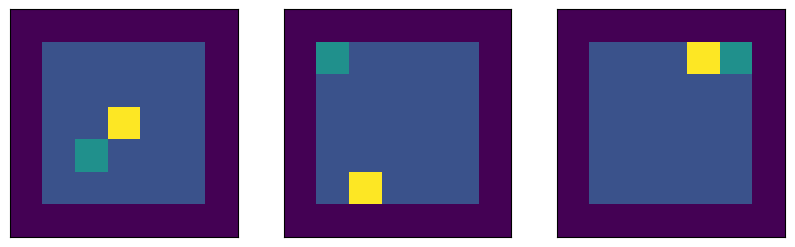

In [2]:
size = 7
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
env_ = get_env()
GAMMA = .9
ITERATIONS = 5000

fig,axs=plt.subplots(1,min(len(env_.boards), 3), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board)

 ### Random policy reward

Just a baseline (not the one you are supposed to develop)

2024-05-09 16:24:47.510687: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-09 16:24:47.510750: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-09 16:24:47.510763: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-09 16:24:47.510817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-09 16:24:47.510849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


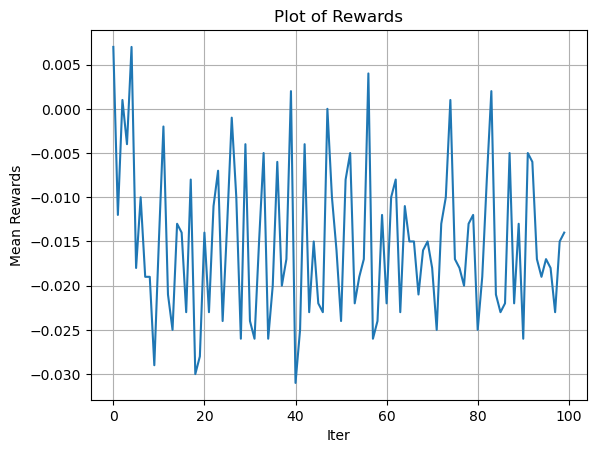

In [3]:
random_env = get_env(100)
random_rewards = []
fruit_data = []
head_data = []
body_data = []

for i in range(100):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # Save the data of the first board
    heads = np.argwhere(random_env.boards == random_env.HEAD) # find the head in the board for all the games
    fruits = np.argwhere(random_env.boards == random_env.FRUIT) # find the fruit in the board for all the games
    bodies = np.argwhere(random_env.boards == random_env.BODY)
    filtered_body = [[row[1], row[2]] for row in bodies if row[0] == 0]

    fruit_data.append([fruits[0][1],fruits[0][2]])
    head_data.append([heads[0][1],heads[0][2]])
    body_data.append(filtered_body)

    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

# Plot the reward
plt.plot(range(len(random_rewards)),random_rewards)
plt.xlabel('Iter')
plt.ylabel('Mean Rewards')
plt.title('Plot of Rewards')
plt.grid(True)
plt.show()

# **A2C**

In [4]:
class A2C(tf.keras.Model):
  def __init__(self, n_actions):
        super(A2C, self).__init__()
        self.actor = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dense(n_actions, activation='softmax')
        ])
        self.critic = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dense(1, activation='linear')
        ])

In [5]:
# Example of usage
env = get_env(1)
action_dim = 4  # Dimensionality of the action space

# Create an instance of the QN model
a2c_net = A2C(action_dim)
# Compile the model
a2c_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss=[tf.keras.losses.CategoricalCrossentropy(), tf.keras.losses.MeanSquaredError()],
                 metrics=[['accuracy'], ['accuracy']])

# Example usage: obtain Q-values for a state
state = env.to_state()
action_probs = a2c_net.actor(state)
critic_value = a2c_net.critic(state)

print("Action probabilities:", action_probs)
print("Critic Value:", critic_value)

action = tf.random.categorical(logits=action_probs, num_samples=1)
print("Selected action",action)

Action probabilities: tf.Tensor([[0.4638168  0.12702133 0.14588313 0.26327878]], shape=(1, 4), dtype=float32)
Critic Value: tf.Tensor([[0.24537651]], shape=(1, 1), dtype=float32)
Selected action tf.Tensor([[0]], shape=(1, 1), dtype=int64)


# Collect one step in the environments

In [6]:

def collect_one_step(envs, a2c_net,TEST):
    """
    Collects one transitions S,A,R,S'

    Args:
    - envs: The environments.
    - a2c: The NN.

    Returns:
    - states, actions, rewards, next_states
    """
    
    # Collect the states
    states = envs.to_state()
    #print(envs.boards[0])
    # Compute the actions probabilities
    actions_probs = a2c_net.actor(states)
    #print("act prob:",actions_probs)
    # Sample from them
    if TEST:
        # Find the index of the action with the maximum probability for each element in the batch
        max_indices = tf.argmax(actions_probs, axis=1)
        # Reshape max_indices
        actions = tf.reshape(max_indices, (-1, 1))
    else:
        actions = tf.random.categorical(tf.math.log(actions_probs), 1)
    
    # Move in the environment and collect the rewards
    rewards = envs.move(actions)
    # Collect next states
    next_states = envs.to_state()

    return states, actions, rewards, next_states


In [7]:
# Example of usage
# Initialize the environment
envs = get_env(256)
action_dim = 4  # Dimensionality of the action space

# Create an instance of the QN model
a2c_net = A2C(action_dim)

TEST = True

states, actions, rewards, next_states = collect_one_step(envs, a2c_net,TEST)

print(states.shape, actions.shape, rewards.shape, next_states.shape)

(256, 7, 7, 4) (256, 1) (256, 1) (256, 7, 7, 4)


In [8]:
def get_length(bodies, total_envs):
  # Get unique board numbers and their counts
  board_numbers, counts = np.unique(bodies[:, 0], return_counts=True)

  # Create a tensor with all board numbers and initial count of 1
  lengths = np.ones((total_envs, 1), dtype=int)

  # Update the tensor with counts from the data
  for board_number, count in zip(board_numbers, counts):
      lengths[int(board_number) - 1] = count +1

  lengths_tensor = tf.convert_to_tensor(lengths)
  lengths_tensor = tf.cast(lengths_tensor, tf.float32)

  return lengths_tensor

# Mod Rewards

In [9]:
def mod_rewards(envs, rewards, train_step):
    
    if train_step > 0:

        lengths = get_length(np.argwhere(envs.boards == envs.BODY), envs.n_boards)
        
        condition = tf.logical_and(tf.greater(lengths, 5), tf.equal(rewards, -0.2))
        rewards = tf.where(tf.equal(rewards, -0.2), -0.5, rewards)

        #condition = tf.logical_and(tf.greater(lengths, 10), tf.equal(rewards, -0.2))
        #rewards = tf.where(tf.equal(rewards, -0.2), -1, rewards)

        #condition = tf.logical_and(tf.greater(lengths, 15), tf.equal(rewards, -0.2))
        #rewards = tf.where(tf.equal(rewards, -0.2), -1.5, rewards)

        #condition = tf.logical_and(tf.greater(lengths, 20), tf.equal(rewards, -0.2))
        #rewards = tf.where(tf.equal(rewards, -0.2), -2, rewards)

        condition = tf.logical_and(tf.greater(lengths, 5), tf.equal(rewards, 0.5))
        rewards = tf.where(condition, 0.6, rewards)

        condition = tf.logical_and(tf.greater(lengths, 10), tf.equal(rewards, 0.5))
        # Apply the modification
        rewards = tf.where(condition, 0.8, rewards)

        condition = tf.logical_and(tf.greater(lengths, 15), tf.equal(rewards, 0.5))
        # Apply the modification
        rewards = tf.where(condition, 1.1, rewards)

        condition = tf.logical_and(tf.greater(lengths, 20), tf.equal(rewards, 0.5))
        # Apply the modification
        rewards = tf.where(condition, 1.5, rewards)

        win = 2.
        rewards = tf.where(tf.equal(rewards, 1.), win, rewards)
    
    return rewards

# Plot

In [10]:
def plotting(max_steps, n_fruit_eaten, n_wall_hit, n_body_hit, rewards):
  # Create a figure and axis objects
  fig, axs = plt.subplots(1, 4, figsize=(15, 5))

  # Plot n_fruit_eaten
  axs[0].plot(range(1, max_steps + 1), n_fruit_eaten)
  axs[0].set_xlabel('Training Steps')
  axs[0].set_ylabel('Eaten fruits')
  axs[0].set_title('Eaten fruits over Training Steps')
  axs[0].grid(True)

  # Plot n_wall_hit
  axs[1].plot(range(1, max_steps + 1), n_wall_hit)
  axs[1].set_xlabel('Training Steps')
  axs[1].set_ylabel('Wall hit')
  axs[1].set_title('Wall hit over Training Steps')
  axs[1].grid(True)

  # Plot n_body_hit
  axs[2].plot(range(1, max_steps + 1), n_body_hit)
  axs[2].set_xlabel('Training Steps')
  axs[2].set_ylabel('Body hit')
  axs[2].set_title('Body hit over Training Steps')
  axs[2].grid(True)

  # Plot n_fruit_eaten
  axs[3].plot(range(1, max_steps + 1), rewards)
  axs[3].set_xlabel('Training Steps')
  axs[3].set_ylabel('Rewards')
  axs[3].set_title('Rewards over Training Steps')
  axs[3].grid(True)

  # Adjust layout
  plt.tight_layout()

  # Show the plot
  plt.show()

# Learn

In [11]:

def learn(a2c_net, optimizer_actor, optimizer_critic, gamma, states, next_states, actions, rewards):

  # Inside the training loop
  with tf.GradientTape(persistent=True) as tape_actor, tf.GradientTape(persistent=True) as tape_critic:
      # Compute the states value functions
      val = a2c_net.critic(states)
      #print(val)
      # Compute the next states value functions
      next_val = a2c_net.critic(next_states)
      #print(next_val)
      # Compute the actions probs
      action_probs = a2c_net.actor(states)
      #print(action_probs)
      # Compute the discounted rewards
      td_target = rewards + gamma * next_val # remember (1-dones)
      #print(td_target.shape)
      # Compute advantages
      advantages = (td_target - val)

      # Convert 'actions' to one-hot encoded tensor
      actions_one_hot = tf.one_hot(actions[:, 0], depth=action_probs.shape[-1])

      # Multiply 'action_probs' by 'actions_one_hot' to select the corresponding probabilities
      gathered_probs = tf.reduce_sum(action_probs * actions_one_hot, axis=1)

      # Compute the actor loss
      actor_loss = -tf.math.log(gathered_probs) * tf.squeeze(advantages)
      actor_loss = tf.reduce_mean(actor_loss)
      # Compute the critic loss
      critic_loss = tf.reduce_mean(tf.square(tf.squeeze(advantages)))

  # Compute the gradients from the loss
  grads_actor = tape_actor.gradient(actor_loss, a2c_net.actor.trainable_weights)
  grads_critic = tape_critic.gradient(critic_loss, a2c_net.critic.trainable_weights)

  # Apply the gradients to the model's parameters
  optimizer_actor.apply_gradients(zip(grads_actor, a2c_net.actor.trainable_weights))
  optimizer_critic.apply_gradients(zip(grads_critic, a2c_net.critic.trainable_weights))

  loss = actor_loss + critic_loss

  return loss

# Train

In [12]:
def train(envs, a2c_net, optimizer_actor, optimizer_critic, gamma, max_steps, TEST):

  rewardsF = []
  n_fruit_eaten = []
  n_wall_hit = []
  n_body_hit = []

  for step in trange(1, max_steps + 1):

      # Do one step in the environment
      states, actions, rewards, next_states = collect_one_step(envs, a2c_net,TEST)
      
      n_fruit_eaten.append(np.count_nonzero(np.array(rewards) == .5))
      n_wall_hit.append(np.count_nonzero(np.array(rewards) == -.1))
      n_body_hit.append(np.count_nonzero(np.array(rewards) == -.2))

      mean_reward = np.mean(np.array(rewards))
      rewardsF.append(mean_reward)

      if step % 1000 == 0:
         print(f"Mean Reward: {round(mean_reward, 4)}")
      
      # rewards = mod_rewards(envs, rewards, step)

      # Learning
      loss = learn(a2c_net, optimizer_actor, optimizer_critic, gamma, states, next_states, actions, rewards)

  print("Training complete!")

  return rewardsF, n_fruit_eaten, n_wall_hit, n_body_hit

# Test

In [13]:
def test(envs, a2c_net, max_steps, TEST):

  rewardsF = []
  fruit_data = []
  head_data = []
  body_data = []
  n_fruit_eaten = [] 
  n_wall_hit = []
  n_body_hit = []

  for step in trange(1, max_steps + 1):

      # Do one step in the environment

      states, actions, rewards, next_states = collect_one_step(envs, a2c_net, TEST)

      # Save the data of the first board
      heads = np.argwhere(envs.boards == envs.HEAD) # find the head in the board for all the games
      fruits = np.argwhere(envs.boards == envs.FRUIT) # find the fruit in the board for all the games
      bodies = np.argwhere(envs.boards == envs.BODY)
      filtered_body = [[row[1], row[2]] for row in bodies if row[0] == 0]

      fruit_data.append([fruits[0][1],fruits[0][2]])
      head_data.append([heads[0][1],heads[0][2]])
      body_data.append(filtered_body)

      n_fruit_eaten.append(np.count_nonzero(np.array(rewards) == .5))
      n_wall_hit.append(np.count_nonzero(np.array(rewards) == -.1))
      n_body_hit.append(np.count_nonzero(np.array(rewards) == -.2))

      rewardsF.append(np.mean(np.array(rewards)))

  print("Test is completed!")

  return rewardsF, n_fruit_eaten, n_wall_hit, n_body_hit, fruit_data, head_data, body_data

# Do it

In [14]:
# Initialize the environment
envs = get_env(256)
action_dim = 4  # Dimensionality of the action space

# Create an instance of the QN model
a2c_net_train = A2C(action_dim)
# Create optimizer for actor and critic separately
optimizer_actor = tf.keras.optimizers.Adam(learning_rate=3e-4)
optimizer_critic = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile the model
a2c_net_train.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss=[tf.keras.losses.CategoricalCrossentropy(), tf.keras.losses.MeanSquaredError()],
                 metrics=[['accuracy'], ['accuracy']])

gamma = 0.99

max_steps = int(20_000)

TEST = False

iterations_per_second = 12

# Calculate total time in seconds
total_seconds = max_steps / iterations_per_second

# Convert seconds to days, hours, and minutes
total_days = total_seconds // (24 * 3600)
remaining_seconds = total_seconds % (24 * 3600)
total_hours = remaining_seconds // 3600
remaining_seconds %= 3600
total_minutes = remaining_seconds // 60

# Print the result
print(f"Training time: {int(total_days)} days, {int(total_hours)} hours, {int(total_minutes)} minutes.")

Training time: 0 days, 0 hours, 27 minutes.


In [15]:
# Run training
rewards_tr, n_fruit_eaten_tr, n_wall_hit_tr, n_body_hit_tr = train(envs, a2c_net_train, optimizer_actor, optimizer_critic, gamma, max_steps, TEST)

  5%|▌         | 1001/20000 [01:30<29:29, 10.74it/s]

Mean Reward: -0.0012000000569969416


 10%|█         | 2001/20000 [02:55<29:22, 10.21it/s]

Mean Reward: 0.017999999225139618


 15%|█▌        | 3000/20000 [04:23<22:57, 12.34it/s]

Mean Reward: 0.11599999666213989


 20%|██        | 4001/20000 [05:49<22:58, 11.61it/s]

Mean Reward: 0.09920000284910202


 25%|██▌       | 5000/20000 [07:18<20:31, 12.18it/s]

Mean Reward: 0.1031000018119812


 30%|███       | 6001/20000 [08:44<19:47, 11.79it/s]

Mean Reward: 0.12809999287128448


 35%|███▌      | 7000/20000 [10:08<17:25, 12.44it/s]

Mean Reward: 0.09529999643564224


 40%|████      | 8000/20000 [11:36<16:16, 12.29it/s]

Mean Reward: 0.1031000018119812


 45%|████▌     | 9001/20000 [13:03<15:34, 11.77it/s]

Mean Reward: 0.09769999980926514


 50%|█████     | 10001/20000 [14:35<15:47, 10.55it/s]

Mean Reward: 0.1046999990940094


 55%|█████▌    | 11000/20000 [16:09<12:39, 11.86it/s]

Mean Reward: 0.125


 60%|██████    | 12000/20000 [17:32<10:58, 12.15it/s]

Mean Reward: 0.1234000027179718


 65%|██████▌   | 13000/20000 [18:54<09:51, 11.83it/s]

Mean Reward: 0.1137000024318695


 70%|███████   | 14001/20000 [20:17<08:06, 12.33it/s]

Mean Reward: 0.09449999779462814


 75%|███████▌  | 15000/20000 [21:41<06:56, 11.99it/s]

Mean Reward: 0.0940999984741211


 80%|████████  | 16000/20000 [23:08<10:10,  6.55it/s]

Mean Reward: 0.10429999977350235


 85%|████████▌ | 17001/20000 [24:33<04:09, 12.03it/s]

Mean Reward: 0.10080000013113022


 90%|█████████ | 18001/20000 [25:56<02:41, 12.37it/s]

Mean Reward: 0.09880000352859497


 95%|█████████▌| 19000/20000 [27:19<01:54,  8.77it/s]

Mean Reward: 0.1354999989271164


100%|██████████| 20000/20000 [28:47<00:00, 11.58it/s]

Mean Reward: 0.11020000278949738
Training complete!


### Save the weights

In [16]:
a2c_net_train.save_weights('weights_a2c_rew.weights.h5')

### Plot the results

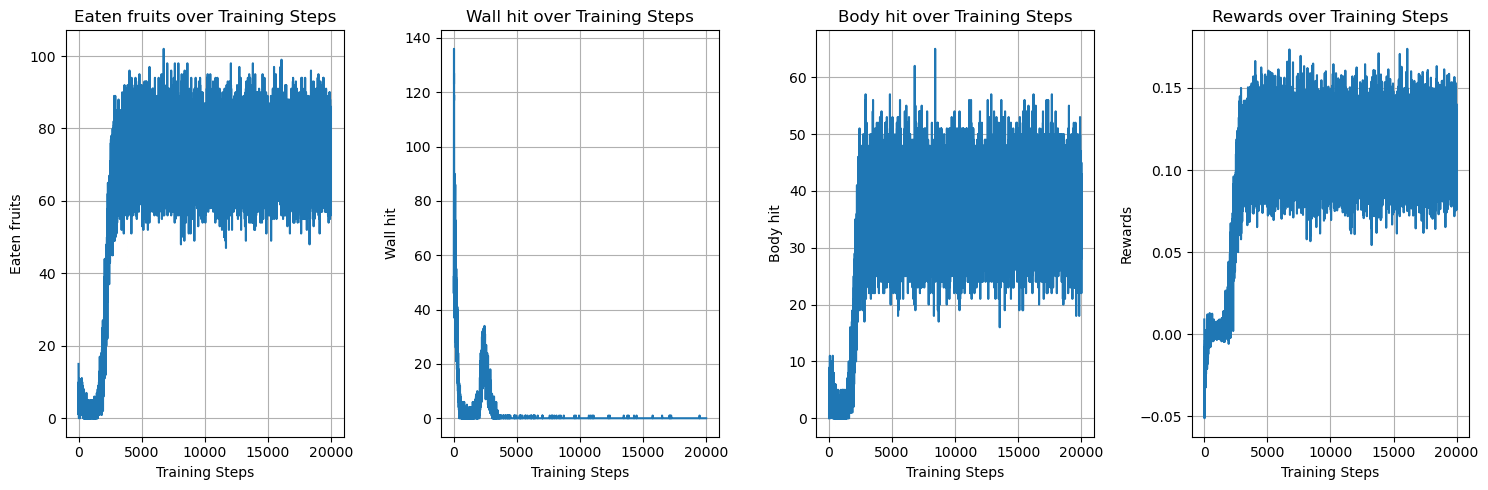

In [17]:
plotting(max_steps, n_fruit_eaten_tr, n_wall_hit_tr, n_body_hit_tr, rewards_tr)

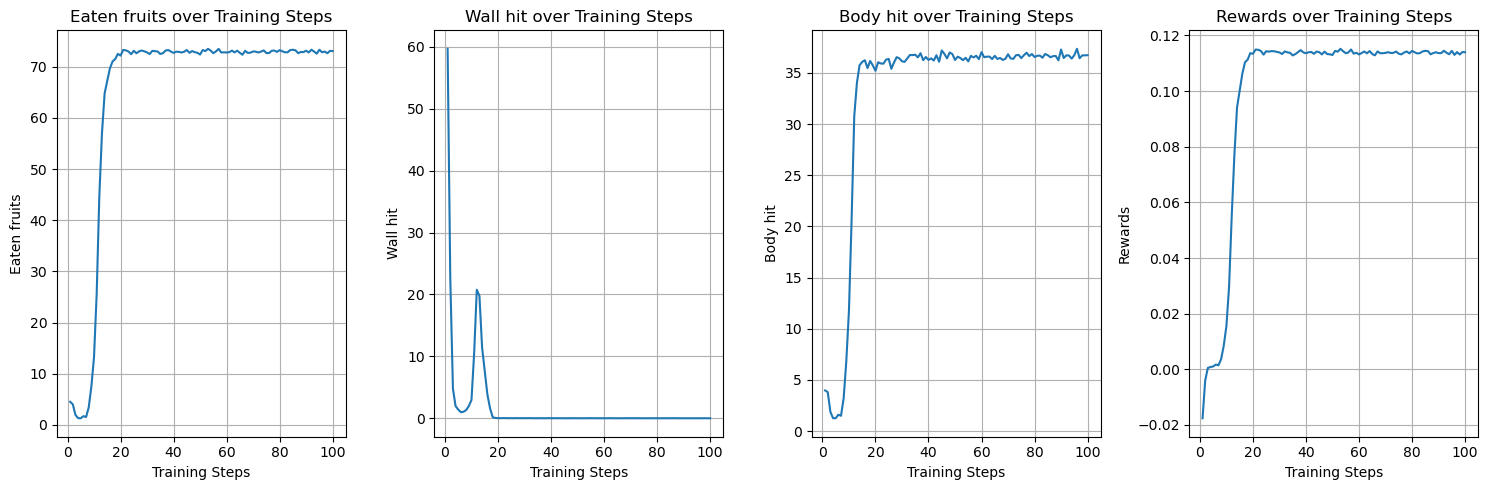

In [18]:
rewards_ep = np.mean(np.reshape(rewards_tr, (100, 200)), axis=1)
n_fruit_eaten_ep = np.mean(np.reshape(n_fruit_eaten_tr, (100, 200)), axis=1)
n_wall_hit_ep = np.mean(np.reshape(n_wall_hit_tr, (100, 200)), axis=1)
n_body_hit_ep = np.mean(np.reshape(n_body_hit_tr, (100, 200)), axis=1)
max_steps = rewards_ep.shape[0]

plotting(max_steps, n_fruit_eaten_ep, n_wall_hit_ep, n_body_hit_ep, rewards_ep)

### Save the data

In [19]:
# Save the data
np.savez("data_a2c_rewards.npz", max_steps=max_steps, n_fruit_eaten_ep=n_fruit_eaten_ep, n_wall_hit_ep=n_wall_hit_ep, n_body_hit_ep=n_body_hit_ep, rewards_ep=rewards_ep)

# Test

100%|██████████| 5000/5000 [00:55<00:00, 89.98it/s]


Test is completed!


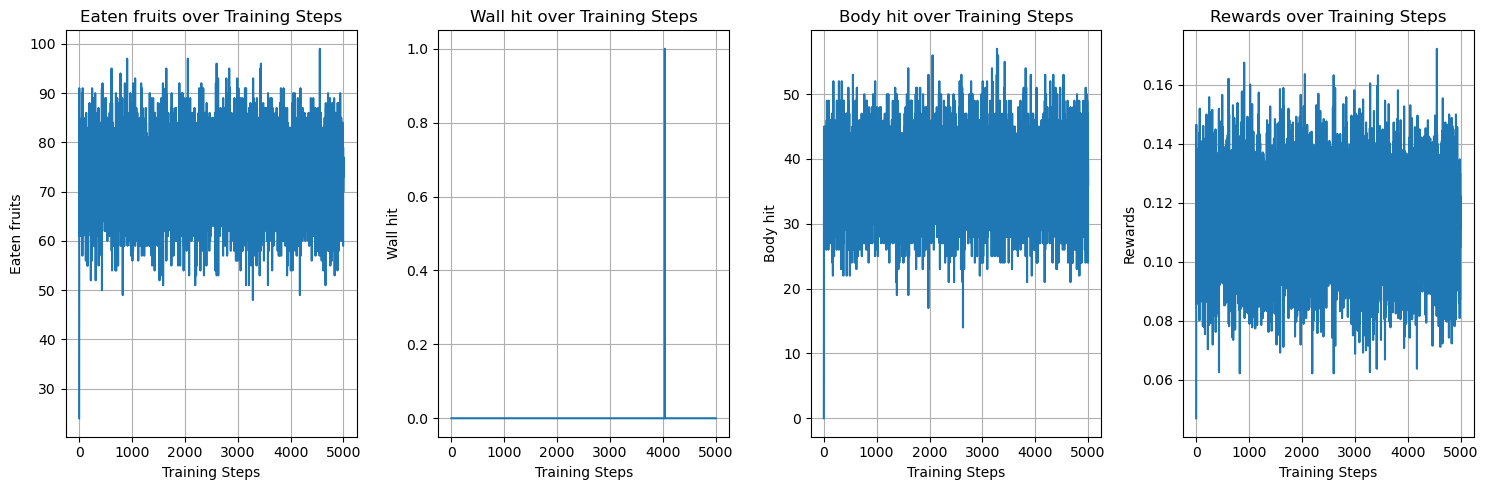

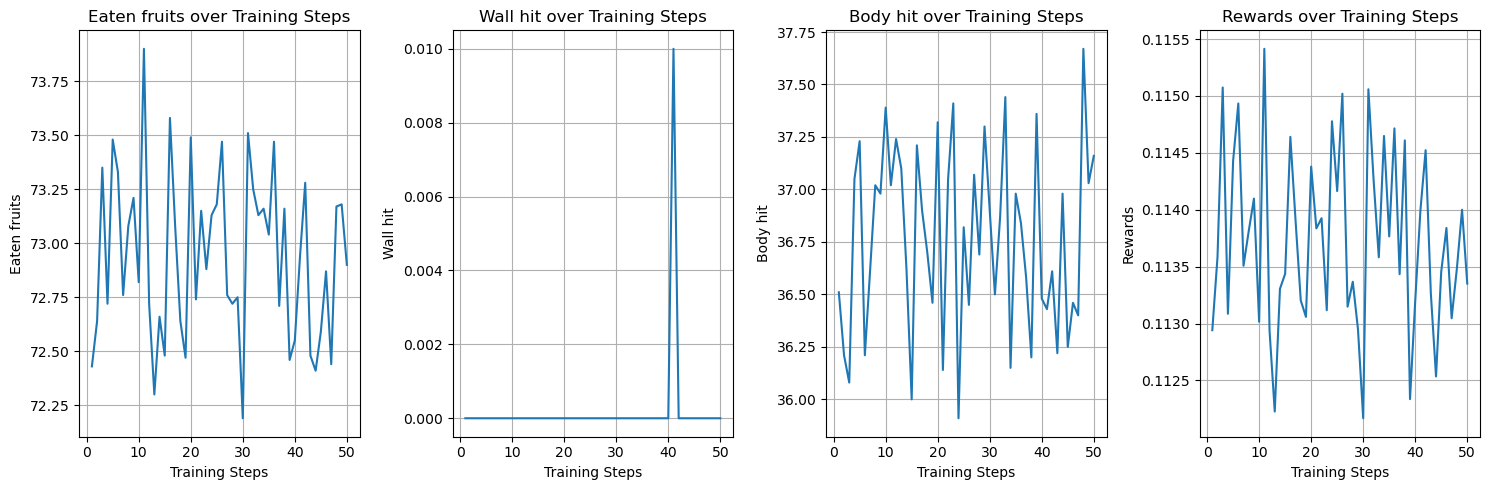

In [20]:
# Initialize the environment
envs = get_env(256)
action_dim = 4  # Dimensionality of the action space

# Create an instance of the Net model
a2c_net_test = A2C(action_dim)
# Create optimizer for actor and critic separately
optimizer_actor = tf.keras.optimizers.Adam(learning_rate=1e-3)
optimizer_critic = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile the model
a2c_net_test.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss=[tf.keras.losses.CategoricalCrossentropy(), tf.keras.losses.MeanSquaredError()],
                 metrics=[['accuracy'], ['accuracy']])

# Call the model with some dummy input to initialize the weights
a2c_net_test.critic(states)
a2c_net_test.actor(states)

a2c_net_test.load_weights('weights_a2c_rew.weights.h5')

max_steps = int(5000)

TEST = True

rewards, n_fruit_eaten, n_wall_hit, n_body_hit, fruit_data, head_data, body_data = test(envs, a2c_net_test, max_steps, TEST)

plotting(max_steps, n_fruit_eaten, n_wall_hit, n_body_hit, rewards)

rewards_ep = np.mean(np.reshape(rewards, (50, 100)), axis=1)
n_fruit_eaten_ep = np.mean(np.reshape(n_fruit_eaten, (50, 100)), axis=1)
n_wall_hit_ep = np.mean(np.reshape(n_wall_hit, (50, 100)), axis=1)
n_body_hit_ep = np.mean(np.reshape(n_body_hit, (50, 100)), axis=1)
max_steps = rewards_ep.shape[0]

plotting(max_steps, n_fruit_eaten_ep, n_wall_hit_ep, n_body_hit_ep, rewards_ep)

# Video rendering

Finished


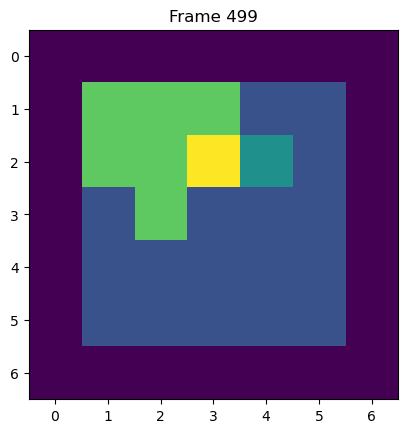

In [21]:
from baseline import *

max_steps = 500
game_animation(envs, head_data, body_data, fruit_data, max_steps, size)

print("Finished")